# 4.2. Analyse des échantillons


## 4.2.1. Nombre d’échantillons

### Nombre de polygones par classe

#### Diagramme en bâtons

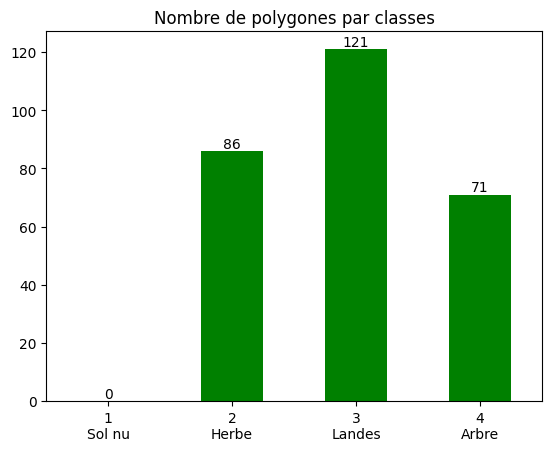

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os

shp_path = os.path.join(
    "data",
    "projet_eval",
    "PI_strates_bretagne_32630.shp"
)

echantillon_shp = gpd.read_file(shp_path)

# Dictionnaire de référence car la liste des classes est connue d'avance
labels_strates = {
    1: "Sol nu",
    2: "Herbe",
    3: "Landes",
    4: "Arbre"
}

# Compter et forcer les strates attendues
counts = (
    echantillon_shp["strate"]
    .value_counts()
    .reindex(labels_strates.keys())
    .fillna(0)
)

fig, ax = plt.subplots()
counts.plot(kind="bar", ax=ax, color="green")

# Affiche les valeurs
for i, val in enumerate(counts):
    ax.text(i, val, int(val), ha="center", va="bottom") 

# Labels de l'axe X depuis le dictionnaire
ax.set_xticklabels([f"{s}\n{labels_strates[s]}" for s in counts.index], rotation=0)

# Titres graphique et axes
ax.set_title("Nombre de polygones par classes")
plt.xlabel('')
plt.ylabel('')

# Sortie
output_dir = os.path.join("results", "figure")

os.makedirs(output_dir,exist_ok=True) # Crée le dossier s'il n'existe pas

output_path = os.path.join(output_dir, "diag_baton_nb_poly_by_class.png")

plt.savefig(output_path)

plt.show()

#### Commentaire

On remarque que la distribution des échantillons est **déséquilibrée** : les landes sont la classe majoritaire tandis que **la classe « sol nu » est totalement absente**.

Cela pourra poser des problèmes plus tard, notamment lors de la classification supervisée, en créant des **biais**. En effet, sans échantillon de référence dans cette classe, l'apprentissage sera impossible pour cette classe. Les résultats seront donc à interpréter avec prudence, notamment pour la classe « sol nu ».

### Nombre de pixels par classe

#### Contrôles

Tout d'abord, on vérifie que tous nos fichiers de travail sont bien « **alignés** » : même résolution, même CRS, mêmes coordonnées à l'origine, mêmes dimensions. On utilise pour cela principalement des fonctions de ``libsigma``.

##### Résolution spatiale

In [ ]:
from libsigma.read_and_write import get_pixel_size, open_image

data_dir = os.path.join("data", "projet_eval")

# liste des rasters
files = sorted(
    f for f in os.listdir(data_dir)
    if f.startswith("bretagne_24-25")
)

pixel_sizes = [
    get_pixel_size(
        open_image(os.path.join(data_dir, f))
    )
    for f in files
]

if len(set(pixel_sizes)) == 1: # un set supprime les doublons
    print("✅ Toutes les images ont la même résolution. Taille des pixels :", pixel_sizes[0])
else:
    print("❌ Les images n'ont PAS toutes la même résolution !")
    for f, ps in zip(files, pixel_sizes):
        print(f, ":", ps)

✅ Toutes les images ont la même résolution. Taille des pixels : (10.0, -10.0)


##### Système de projection

In [ ]:
crs_list = [
    open_image(os.path.join(data_dir, f)).GetProjection()
    for f in files
]

if len(set(crs_list)) == 1:
    print("✅ Toutes les images ont le même CRS :", crs_list[0])
else:
    print("❌ Les images n'ont PAS toutes le même CRS")
    for f, crs in zip(files, crs_list):
        print(f, ":", crs)

✅ Toutes les images ont le même CRS : PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]


##### Coordonnées du pixel à l'origine

In [ ]:
from libsigma.read_and_write import get_origin_coordinates

origins = [
    get_origin_coordinates(
        open_image(os.path.join(data_dir, f))
    )
    for f in files
]

if len(set(origins)) == 1:
    print("✅ Toutes les images ont la même origine :", origins[0])
else:
    print("❌ Les images n'ont PAS la même origine")
    for f, origin in zip(files, origins):
        print(f, ":", origin)


✅ Toutes les images ont la même origine : (432950.0, 5368890.0)


##### Dimensions

In [38]:
from libsigma.read_and_write import get_image_dimension

dimensions = [
    get_image_dimension(
        open_image(os.path.join(data_dir, f))
    )   # on ne garde que (nb_lignes, nb_colonnes)
    for f in files
]

if len(set(dimensions)) == 1:
    print("✅ Toutes les images ont la même dimension :", dimensions[0])
else:
    print("❌ Les images n'ont PAS toutes la même dimension")
    for f, dim in zip(files, dimensions):
        print(f, ":", dim)

✅ Toutes les images ont la même dimension : (612, 1533, 6)


La fonction `get_image_dimension()` renvoie un triplet *(lignes, colonnes, bandes)*.

Les dimensions spatiales (lignes et colonnes) sont identiques pour toutes les images, ce qui confirme leur bon alignement.

En revanche, la présence de **6 bandes** par fichier est suspecte étant donné que les images Sentinel-2 comportent 13 bandes (dont on en sélectionne couramment 10).

On comprend donc que ces 6 bandes correspondent aux **6 dates d’acquisition**, et non à des bandes spectrales. Les différentes bandes spectrales sont donc réparties entre plusieurs fichiers (ce qui est cohérent avec leur nom « ``BXX`` »), chacun empilant les informations temporelles.

En l'état, le jeu de données fourni n'est **pas exploitable** car l’organisation des images est différente : **chaque fichier correspond à une bande spectrale** donnée, dans laquelle est « empilée » la **dimension temporelle**.

Afin de pouvoir travailler sur ces fichiers, il est donc nécessaire de **réorganiser ces données**.

#### Réorganisation des données

#### Diagramme en bâtons

## 4.2.2. Phénologie des strates, mise en évidence des landes

# 4.3. Production d'une carte de strates à l'échelle du pixel

## 4.3.1. Choix du classifieur et sa paramétrisation

## 4.3.2. Stratégie de validation

## 4.3.3. Contribution des variables

## 4.3.4. Production des cartes finales

## 4.3.5. Analyse des résultats